## Лабораторная работа №2

## Импортируем библиотеки

In [379]:
from csv import DictWriter
from typing import Union

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC

### Загрузка данных

In [380]:
try:
    # Чтение данных обучения из файла CSV
    train_dataframe = pd.read_csv("train.csv")
except Exception as e:
    print(f"Произошла ошибка при чтении файла train.csv: {e}")
train_dataframe

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
1,426,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,A/4. 34244,7.2500,NaN,S
2,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
3,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
4,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
...,...,...,...,...,...,...,...,...,...,...,...,...
529,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
530,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.0750,NaN,S
531,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
532,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S


### Предварительная обработка данных

#### Анализ данных

Выведем сводную информацию о DataFrame. Так как столбцы находящиеся в списке columns_to_remove не влияют на целевую переменную, удалим их из DataFrame. Удалим Столбец Cabin из-за большого количества пропусков.

In [381]:
print(train_dataframe.info())

columns_to_remove = ["PassengerId", "Name", "Ticket", "Cabin"]
train_dataframe = train_dataframe.drop(columns=columns_to_remove)

category = ("Survived", "Pclass", "Sex", "Embarked")
numeric = ("Age", "SibSp", "Parch", "Fare")

for col in category:
    print(f"{col}: {train_dataframe[col].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  534 non-null    int64  
 1   Survived     534 non-null    int64  
 2   Pclass       534 non-null    int64  
 3   Name         534 non-null    object 
 4   Sex          534 non-null    object 
 5   Age          432 non-null    float64
 6   SibSp        534 non-null    int64  
 7   Parch        534 non-null    int64  
 8   Ticket       534 non-null    object 
 9   Fare         534 non-null    float64
 10  Cabin        120 non-null    object 
 11  Embarked     534 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 50.2+ KB
None
Survived: [0 1]
Pclass: [3 1 2]
Sex: ['female' 'male']
Embarked: ['S' 'C' 'Q']


Восстановим пропущенные значения используя различные методы:

### Метод KNN

In [382]:
knn_imputer = KNNImputer()
train_dataframe["Age"] = knn_imputer.fit_transform(train_dataframe[["Age"]]).ravel()

train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  534 non-null    int64  
 1   Pclass    534 non-null    int64  
 2   Sex       534 non-null    object 
 3   Age       534 non-null    float64
 4   SibSp     534 non-null    int64  
 5   Parch     534 non-null    int64  
 6   Fare      534 non-null    float64
 7   Embarked  534 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 33.5+ KB


### Кодирование и нормализация данных

### Качественные переменные

In [383]:
encoder = LabelEncoder()
for col in category:
    train_dataframe[col] = encoder.fit_transform(train_dataframe[col].astype(str))

### Построение диаграмм раccеивания

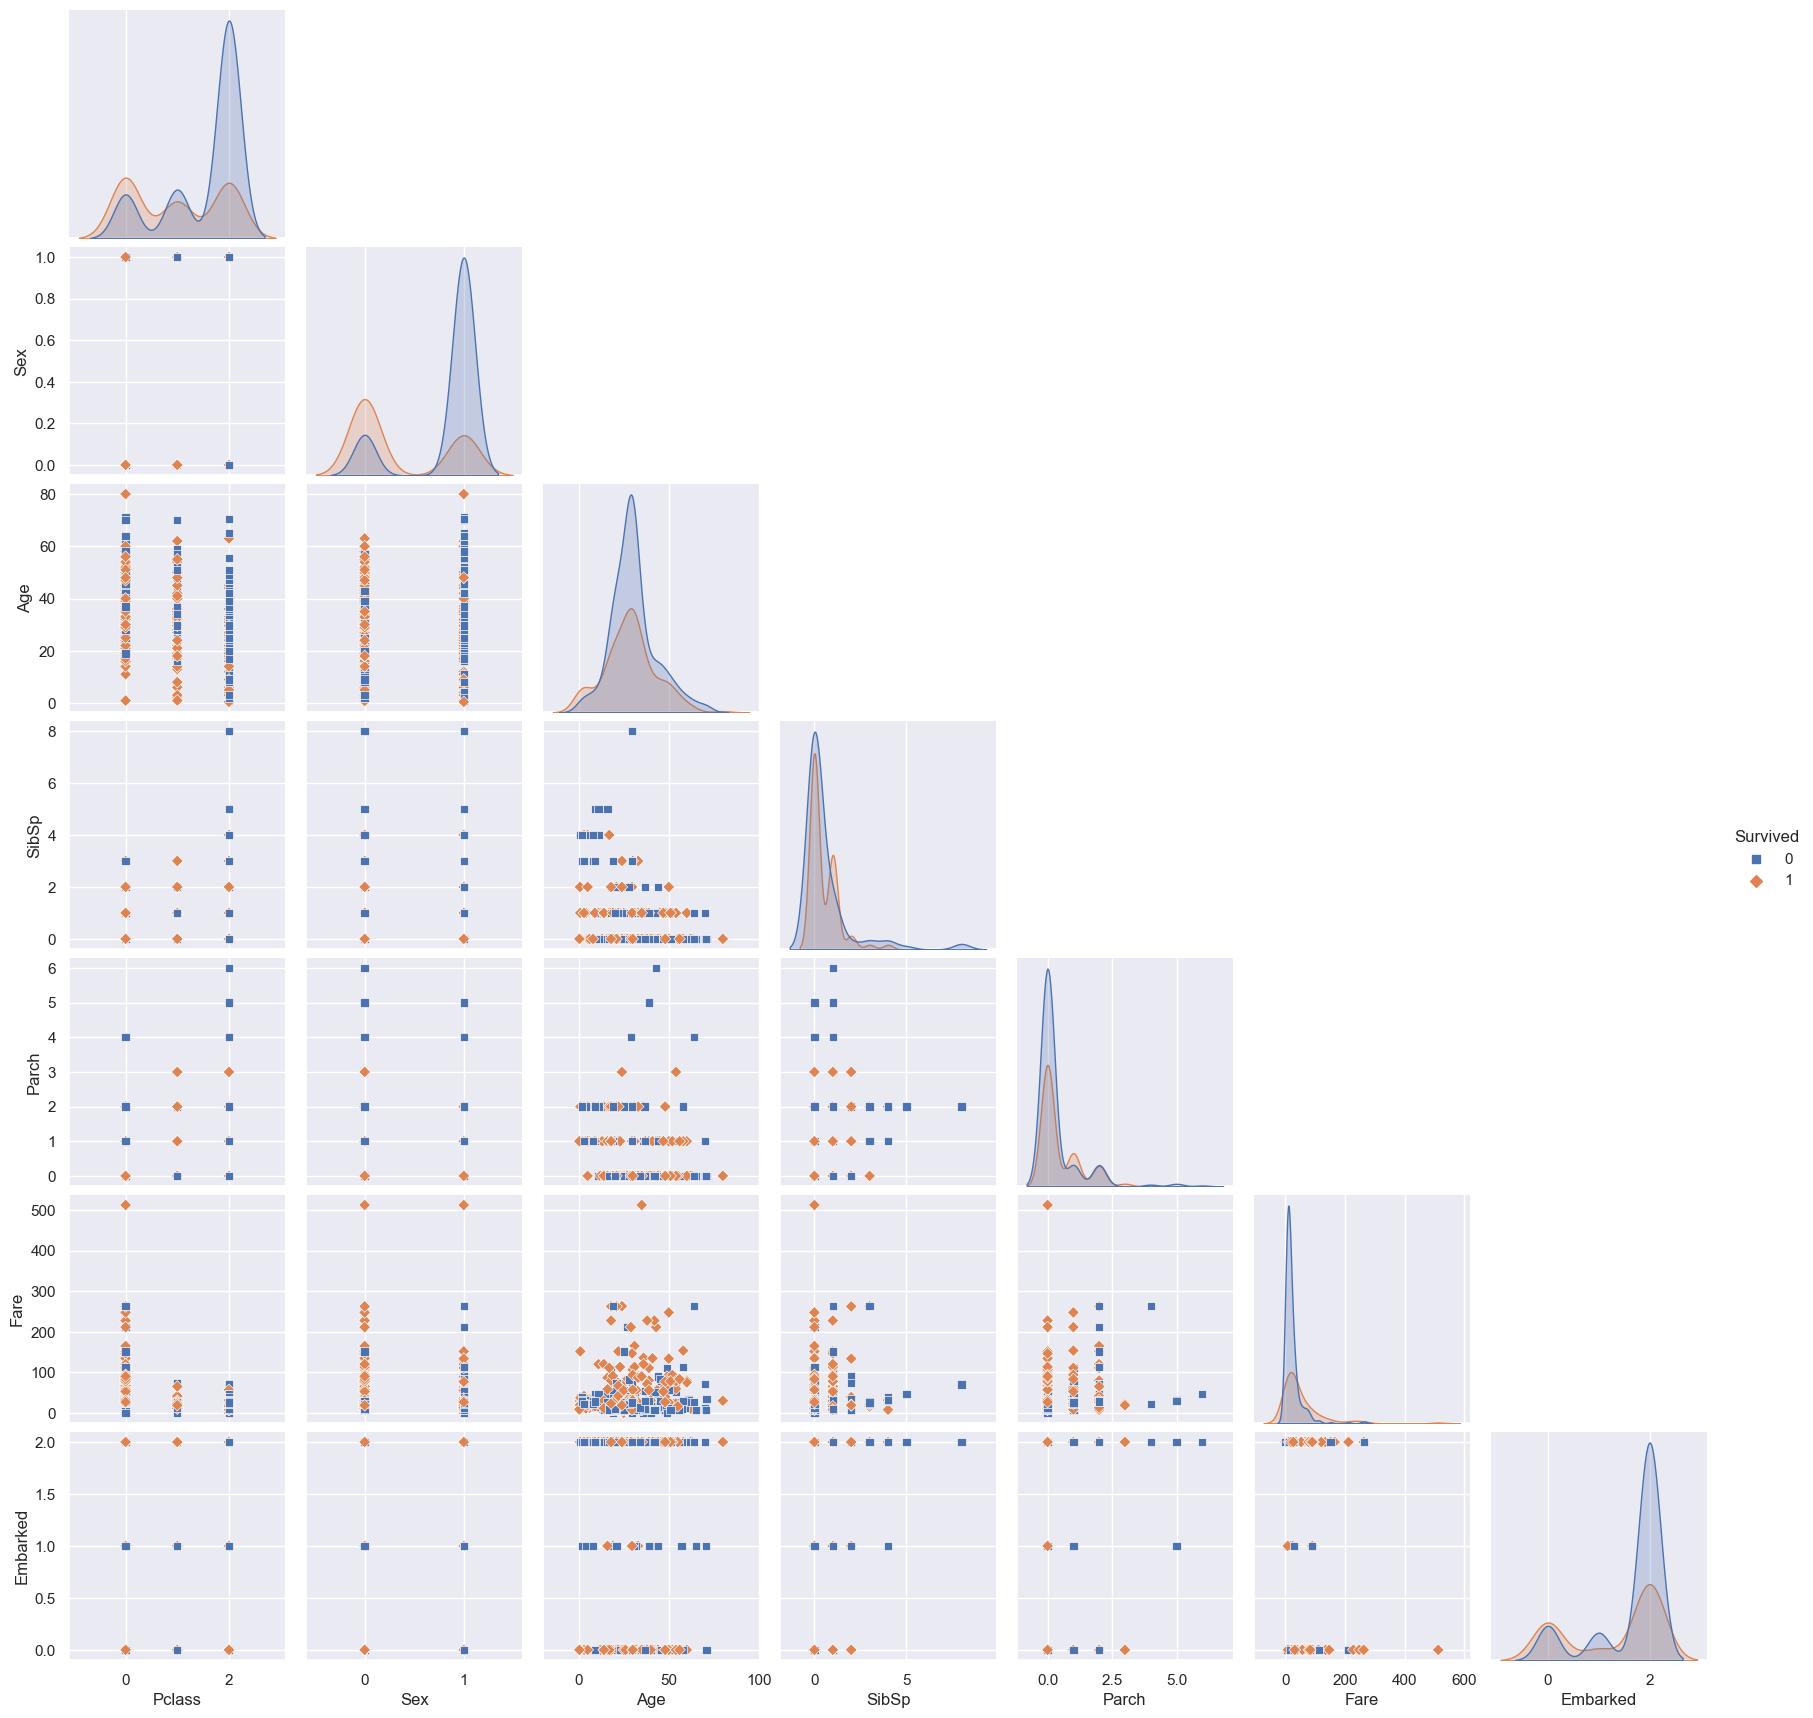

In [384]:
sns.set_theme(style="darkgrid")
sns.pairplot(train_dataframe, hue="Survived", corner=True, markers=["s", "D"])

### Количественные переменные

In [385]:
scaler = MinMaxScaler()
for col in numeric:
    train_dataframe[col] = pd.DataFrame(scaler.fit_transform(train_dataframe[[col]]))

train_dataframe

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,2,0,0.366834,0.375,0.166667,0.049708,2
1,0,2,1,0.366834,0.000,0.000000,0.014151,2
2,1,0,0,0.535059,0.000,0.166667,0.412503,2
3,1,1,0,0.296306,0.000,0.333333,0.028302,2
4,1,1,1,0.007288,0.250,0.166667,0.076123,2
...,...,...,...,...,...,...,...,...
529,0,2,0,0.019854,0.375,0.333333,0.054457,2
530,0,2,0,0.032420,0.375,0.166667,0.041136,2
531,0,2,1,0.366834,0.375,0.166667,0.049708,2
532,1,1,0,0.296306,0.250,0.500000,0.036598,2


## Проверка нормализации

In [386]:
for col in numeric:
    print(f"{col}: min = {train_dataframe[col].min()}, max = {train_dataframe[col].max()}")

Age: min = 0.0, max = 1.0
SibSp: min = 0.0, max = 1.0
Parch: min = 0.0, max = 1.0
Fare: min = 0.0, max = 1.0


## Деление данных

In [387]:
x = train_dataframe.drop(columns=["Survived"])
y = train_dataframe["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)

### Отбор информативных признаков

In [388]:
masks = scoring = tuple()

#### Тестирование со всеми признаками

In [389]:
model = GaussianNB().fit(x_train, y_train)
masks += ([True for _ in range(x_train.shape[1])],)
scoring += (round(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]), 3),)
print("Score (ROC-AUC): " + str(scoring[-1]))

Score (ROC-AUC): 0.844


In [390]:
def select_features(selector, masks: tuple[list[bool]], scoring: tuple[tuple[float]]) -> tuple[
    tuple[Union[list[bool], tuple[float]]]]:
    """Получить маску оптимальных переменных и счет теста."""
    selector.fit(x, y)
    model = GaussianNB().fit(selector.transform(x_train), y_train)

    masks += (selector.get_support(),)
    scoring += (round(roc_auc_score(y_test, model.predict_proba(selector.transform(x_test))[:, 1]), 3),)

    print("Score (ROC-AUC): " + str(scoring[-1]))
    return (masks, scoring)

#### Отбор признаков методом фильтрации и тестирование

In [391]:
skb = SelectKBest(k=5)
masks, scoring = select_features(skb, masks, scoring)

Score (ROC-AUC): 0.841


#### Отбор признаков методом-оберткой и тестирование

In [392]:
sfs = SequentialFeatureSelector(GaussianNB(), n_features_to_select=5, n_jobs=-1, scoring="roc_auc")
masks, scoring = select_features(sfs, masks, scoring)

Score (ROC-AUC): 0.861


##### Выбор лучшей маски признаков

In [393]:
best_mask = masks[scoring.index(max(scoring))]
x = x.loc[:, best_mask]
x.columns

Index(['Pclass', 'Sex', 'Age', 'Parch', 'Embarked'], dtype='object')

### Сэмплирование

Проанализируем основной, over-sampling и under-sampling наборы данных и выберем лучший.

In [394]:
sampling = [
    (x, y),
    RandomOverSampler().fit_resample(x, y),
    RandomUnderSampler().fit_resample(x, y)
]
scoring = []
print("Score (ROC-AUC):")
for sx, sy in sampling:
    score = round(max(cross_val_score(GaussianNB(), sx, sy, scoring="roc_auc", n_jobs=-1)), 3)
    scoring.append(score)
    print(score)

Score (ROC-AUC):
0.848
0.938
0.847


In [395]:
x, y = sampling[scoring.index(max(scoring))]

## Повторное деление данных

In [396]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)

## Построение моделей

### В некоторых случаях в param_grid указаны возможные значения гиперпараметров, лучшие варианты из которых будут подобраны на перекрестной проверке

In [397]:

def create_train_model(clf, param_grid: dict = {}) -> GridSearchCV:
    if param_grid is None:
        param_grid = {}
    model = GridSearchCV(clf, param_grid, n_jobs=-1, scoring="roc_auc")
    model.fit(x_train, y_train)
    if param_grid:
        print("Оценщик:", model.best_estimator_)
    print(f"Score (ROC_AUC): {model.score(x_test, y_test):.3f}")
    return model

## Логистическая регрессия

In [398]:
param_grid = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-4, 4, 100),
    "solver": ["saga", "liblinear"],
    "max_iter": range(500, 10001, 500)
}

lg = create_train_model(LogisticRegression(), param_grid)

Оценщик: LogisticRegression(C=31.257158496882415, max_iter=500, solver='saga')
Score (ROC_AUC): 0.867


#### Метод ближайших соседей

In [399]:
param_grid = {
    "n_neighbors": range(1, 100),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "yule", "hamming", "sokalmichener",
               "canberra", "rogerstanimoto", "correlation",
               "euclidean", "cityblock", "l1", "l2", "p",
               "infinity", "chebyshev", "matching", "braycurtis",
               "minkowski", "sqeuclidean", "nan_euclidean",
               "jaccard", "dice", "cosine", "sokalsneath",
               "kulsinski", "russellrao"]
}

knc = create_train_model(KNeighborsClassifier(), param_grid)

Оценщик: KNeighborsClassifier(metric='hamming', n_neighbors=22, weights='distance')
Score (ROC_AUC): 0.850


#### Наивный байесовский классификатор

In [400]:
gnb = create_train_model(GaussianNB())

Score (ROC_AUC): 0.862


### Линейный дискриминантный анализ

In [401]:
lda = create_train_model(LinearDiscriminantAnalysis())

Score (ROC_AUC): 0.865


### Квадратичный дискриминантный анализ

In [402]:
qda = create_train_model(QuadraticDiscriminantAnalysis())

Score (ROC_AUC): 0.860


### Машина опорных векторов

In [403]:
svc = create_train_model(SVC(probability=True))

Score (ROC_AUC): 0.846


#### Тестирование полученных моделей

In [404]:
models = (lg, knc, gnb, lda, qda, svc)
names = []
scoring = []
probs = []
for model in models:
    names.append(model.best_estimator_.__class__.__name__)
    scoring.append(round(model.score(x_test, y_test), 3))
    probs.append(model.predict_proba(x_test)[:, 1])

#### Построение ROC кривых и столбчатой диаграммы score

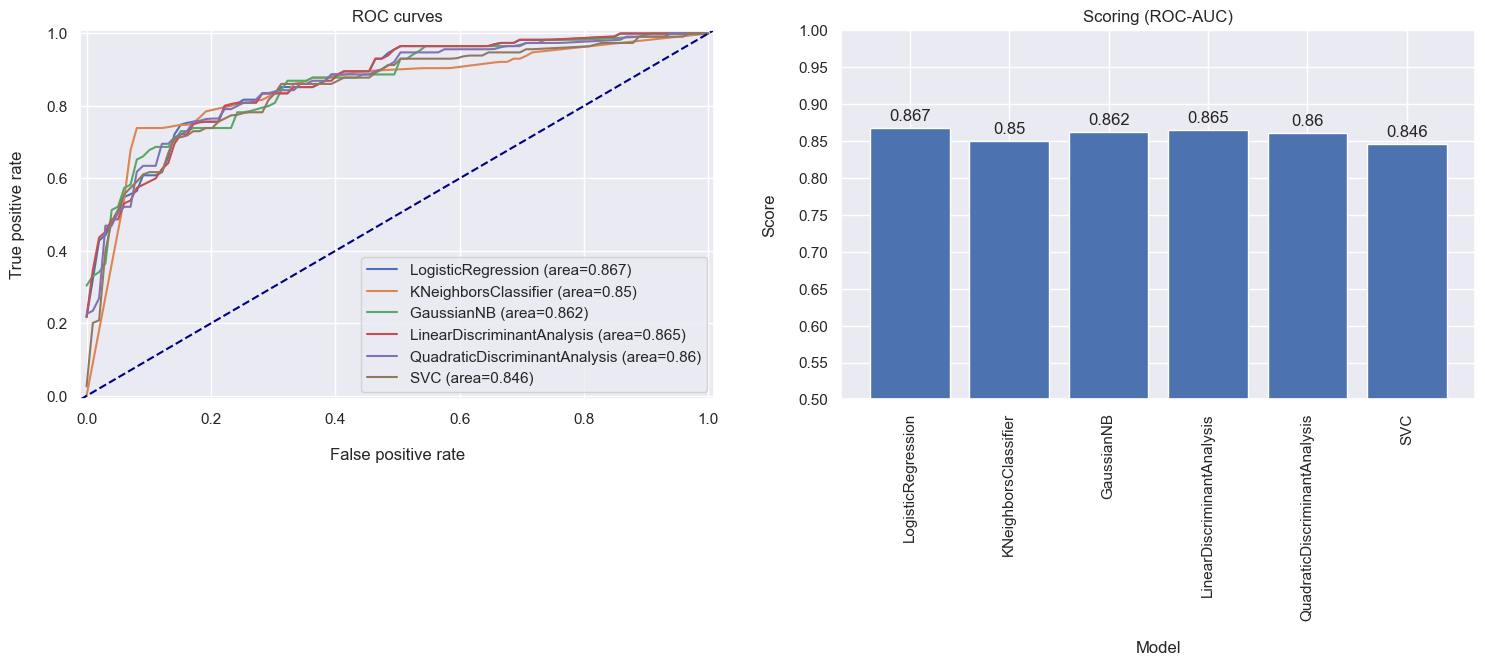

In [416]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(18)

labels = []
for i, prob in enumerate(probs):
    fpr, tpr, _ = roc_curve(y_test, prob, drop_intermediate=False)
    area = round(auc(fpr, tpr), 3)
    labels.append(names[i] + f" (area={area})")

    # Generate more points along the curve
    fpr_smooth = np.linspace(0, 1, 100)
    tpr_smooth = np.interp(fpr_smooth, fpr, tpr)
    axes[0].plot(fpr_smooth, tpr_smooth)

axes[0].plot((-0.01, 1.01), (-0.01, 1.01), color="navy", linestyle="--")
axes[0].set_title("ROC curves")
axes[0].set_xlim((-0.01, 1.01))
axes[0].set_ylim((-0.01, 1.01))
axes[0].set_xlabel("False positive rate", labelpad=15)
axes[0].set_ylabel("True positive rate", labelpad=15)
axes[0].legend(loc="lower right", labels=labels)

axes[1].bar(names, scoring)
axes[1].set_title("Scoring (ROC-AUC)")
axes[1].tick_params("x", labelrotation=90)
axes[1].set_ylim((0.5, 1))
axes[1].yaxis.set_major_locator(MultipleLocator(0.05))
axes[1].yaxis.set_minor_locator(MultipleLocator(0.01))

for rect, score in zip(axes[1].patches, scoring):
    axes[1].text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01, score, ha="center")

axes[1].set_xlabel("Model", labelpad=15)
axes[1].set_ylabel("Score", labelpad=15)
plt.show()


##### Используем модель, показавшую наилучший результат

In [406]:
model_to_use = models[scoring.index(max(scoring))]

### Тестирование

#### Считывание данных

Сразу удаляются ненужные столбцы

In [407]:
test_data = pd.read_csv("test.csv")
passenger_id = test_data["PassengerId"]
test_data = test_data.drop(columns=columns_to_remove)
test_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,female,35.0,1,0,52.0000,S
1,3,male,33.0,0,0,7.8958,S
2,1,female,63.0,1,0,77.9583,S
3,1,male,56.0,0,0,35.5000,C
4,3,male,NaN,0,0,7.8958,S
...,...,...,...,...,...,...,...
352,3,female,17.0,0,0,14.4583,C
353,3,male,NaN,0,0,14.5000,S
354,2,male,24.0,2,0,73.5000,S
355,3,female,4.0,1,1,16.7000,S


#### Анализ данных

Выводится статистика

In [408]:
print(test_data.info())

category = category[1:]
unique_values = [test_data[col].unique() for col in category]
print(unique_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    357 non-null    int64  
 1   Sex       357 non-null    object 
 2   Age       282 non-null    float64
 3   SibSp     357 non-null    int64  
 4   Parch     357 non-null    int64  
 5   Fare      357 non-null    float64
 6   Embarked  355 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 19.6+ KB
None
[array([1, 3, 2], dtype=int64), array(['female', 'male'], dtype=object), array(['S', 'C', 'Q', nan], dtype=object)]


#### Восстановление пропущенных значений методом k-ближайщих соседей, нормализация и кодирование

Предварительно восстанавливаются пропуски. Нормализуются количественные переменные, и выводится проверка.

In [409]:
# Создаем объект MinMax-шкалировщика
scaler = MinMaxScaler()

# Заполняем пропущенные значения в столбце "Age" с помощью KNN-импутера
test_data[["Age"]] = knn_imputer.fit_transform(test_data[["Age"]])

# Шкалируем все числовые столбцы с помощью MinMax-шкалировщика
for col in numeric:
    test_data[col] = scaler.fit_transform(test_data[[col]])
    print(f"Минимальное значение {col}: {test_data[col].min()}")
    print(f"Максимальное значение {col}: {test_data[col].max()}")

Минимальное значение Age: 0.0
Максимальное значение Age: 1.0
Минимальное значение SibSp: 0.0
Максимальное значение SibSp: 1.0
Минимальное значение Parch: 0.0
Максимальное значение Parch: 1.0
Минимальное значение Fare: 0.0
Максимальное значение Fare: 1.0


Кодируются качественные переменные

In [410]:
# Кодируем значения столбца "Embarked"
encoded = encoder.fit_transform(test_data["Embarked"])

# Заменяем пропущенные значения на np.nan
encoded = np.where(test_data["Embarked"].isna(), np.nan, encoded)

# Используем KNN-импортер для заполнения пропущенных значений
test_data["Embarked"] = knn_imputer.fit_transform(encoded.reshape(-1, 1)).round().astype(int)

# Кодируем все категориальные столбцы
for col in category:
    test_data[col] = encoder.fit_transform(test_data[col])

Повторный вывод статистики

In [411]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    357 non-null    int64  
 1   Sex       357 non-null    int32  
 2   Age       357 non-null    float64
 3   SibSp     357 non-null    float64
 4   Parch     357 non-null    float64
 5   Fare      357 non-null    float64
 6   Embarked  357 non-null    int64  
dtypes: float64(4), int32(1), int64(2)
memory usage: 18.3 KB


#### Создание файла и предсказание результата

In [412]:
test_data = test_data.loc[:, best_mask]
prediction = model_to_use.predict(test_data)

submission = pd.DataFrame({
    "PassengerId": passenger_id,
    "Survived": prediction
})
submission.to_csv("submission.csv", index=False)